In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_squared_log_error

%matplotlib inline

In [2]:
SEED = 42

df_tr = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_te = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

df_te["SalePrice"] = 0

In [3]:
df_tr.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
df_te.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [5]:
df_tr.fillna(df_tr.median(numeric_only = True), inplace = True)
df_tr.fillna({col: df_tr[col].mode()[0] for col in df_tr.select_dtypes(include=["object", "category"]).columns}, inplace = True)

In [6]:
df_te.fillna(df_tr.median(numeric_only = True), inplace = True)
df_te.fillna({col: df_te[col].mode()[0] for col in df_te.select_dtypes(include=["object", "category"]).columns}, inplace = True)

In [7]:
def label_encode_categoricals(train_df, test_df):
    le = LabelEncoder()

    categorical_columns = train_df.select_dtypes(include=["object", "category"]).columns
    
    for col in categorical_columns:
        print(f"Encoding column: {col}")
        
        le.fit(train_df[col])

        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])

        print(f"Mapping for {col}:")
        for idx, category in enumerate(le.classes_):
            print(f"  {category} -> {idx}")
        print("\n") 
    
    return train_df, test_df

In [8]:
df_tr, df_te = label_encode_categoricals(df_tr, df_te)

Encoding column: MSZoning
Mapping for MSZoning:
  C (all) -> 0
  FV -> 1
  RH -> 2
  RL -> 3
  RM -> 4


Encoding column: Street
Mapping for Street:
  Grvl -> 0
  Pave -> 1


Encoding column: Alley
Mapping for Alley:
  Grvl -> 0
  Pave -> 1


Encoding column: LotShape
Mapping for LotShape:
  IR1 -> 0
  IR2 -> 1
  IR3 -> 2
  Reg -> 3


Encoding column: LandContour
Mapping for LandContour:
  Bnk -> 0
  HLS -> 1
  Low -> 2
  Lvl -> 3


Encoding column: Utilities
Mapping for Utilities:
  AllPub -> 0
  NoSeWa -> 1


Encoding column: LotConfig
Mapping for LotConfig:
  Corner -> 0
  CulDSac -> 1
  FR2 -> 2
  FR3 -> 3
  Inside -> 4


Encoding column: LandSlope
Mapping for LandSlope:
  Gtl -> 0
  Mod -> 1
  Sev -> 2


Encoding column: Neighborhood
Mapping for Neighborhood:
  Blmngtn -> 0
  Blueste -> 1
  BrDale -> 2
  BrkSide -> 3
  ClearCr -> 4
  CollgCr -> 5
  Crawfor -> 6
  Edwards -> 7
  Gilbert -> 8
  IDOTRR -> 9
  MeadowV -> 10
  Mitchel -> 11
  NAmes -> 12
  NPkVill -> 13
  NWAmes -> 14


In [9]:
x = df_tr.drop(columns=["SalePrice"])
y = df_tr["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = SEED)

In [10]:
def scale_numeric_columns(train_df, test_df):
    numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

    if len(numeric_columns) > 0:
        scaler = StandardScaler()  
        train_df[numeric_columns] = scaler.fit_transform(train_df[numeric_columns])
        test_df[numeric_columns] = scaler.transform(test_df[numeric_columns])
        print(f"Scaled numeric columns: {numeric_columns}")
    else:
        print("No numeric columns to scale.")
    
    return train_df, test_df

In [11]:
X_train, X_test = scale_numeric_columns(X_train, X_test)

Scaled numeric columns: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       '

## Models

### Linear Regression

In [12]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
y_pred_linear_reg = linear_reg_model.predict(X_test)
y_pred_linear_reg = np.maximum(0.01, y_pred_linear_reg) 

rmsle_linear_reg = np.sqrt(mean_squared_log_error(y_test, y_pred_linear_reg))
print("Linear Regression RMSLE:", rmsle_linear_reg)

Linear Regression RMSLE: 0.255431826287633


### Ridge Regression

In [13]:
ridge_model = Ridge(alpha = 1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_ridge = np.maximum(0.01, y_pred_ridge) 

rmsle_ridge = np.sqrt(mean_squared_log_error(y_test, y_pred_ridge))
print("Ridge Regression RMSLE:", rmsle_ridge)

Ridge Regression RMSLE: 0.2529152173140159


### Lasso Regression

In [14]:
lasso_model = Lasso(alpha = 0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_lasso = np.maximum(0.01, y_pred_lasso) 

rmsle_lasso = np.sqrt(mean_squared_log_error(y_test, y_pred_lasso))
print("Lasso Regression RMSLE:", rmsle_lasso)

Lasso Regression RMSLE: 0.25540165646819235


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e+09, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


### Decision Tree Regression

In [15]:
deci_tree_reg_model = DecisionTreeRegressor()
deci_tree_reg_model.fit(X_train, y_train)
y_pred_deci_tree_reg = deci_tree_reg_model.predict(X_test)
y_pred_deci_tree_reg = np.maximum(0.01, y_pred_deci_tree_reg) 

rmsle_deci_tree_reg = np.sqrt(mean_squared_log_error(y_test, y_pred_deci_tree_reg))
print("Decision Tree RMSLE:", rmsle_deci_tree_reg)

Decision Tree RMSLE: 0.2202073180697097


### Random Forest Regression

In [16]:
rand_forest_reg_model = RandomForestRegressor(n_estimators = 100)
rand_forest_reg_model.fit(X_train, y_train)
y_pred_rand_forest_reg = rand_forest_reg_model.predict(X_test)
y_pred_rand_forest_reg = np.maximum(0.01, y_pred_rand_forest_reg) 

rmsle_rand_forest_reg = np.sqrt(mean_squared_log_error(y_test, y_pred_rand_forest_reg))
print("Random Forest RMSLE:", rmsle_rand_forest_reg)

Random Forest RMSLE: 0.1543597028264805


### SVR-Support Vector Regression

In [17]:
svr_model = SVR(kernel = 'rbf')
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
y_pred_svr = np.maximum(0.01, y_pred_svr)

rmsle_svr = np.sqrt(mean_squared_log_error(y_test, y_pred_svr))
print("SVR RMSLE:", rmsle_svr)

SVR RMSLE: 0.4320765398641082


### XGBoost

In [18]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb = np.maximum(0.01, y_pred_xgb) 

rmsle_xgb = np.sqrt(mean_squared_log_error(y_test, y_pred_xgb))
print("XGBoost RMSLE:", rmsle_xgb)

XGBoost RMSLE: 0.15454601685840746


### LightGBM

In [19]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_lgb = np.maximum(0.01, y_pred_lgb) 

rmsle_lgb = np.sqrt(mean_squared_log_error(y_test, y_pred_lgb))
print("LightGBM RMSLE:", rmsle_lgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3419
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 73
[LightGBM] [Info] Start training from score 181441.541952
LightGBM RMSLE: 0.14558274803071336


Based on the training results, the top-performing models are XGBoost, LightGBM, and Random Forest Regression. Among them, LightGBM achieved the best performance.

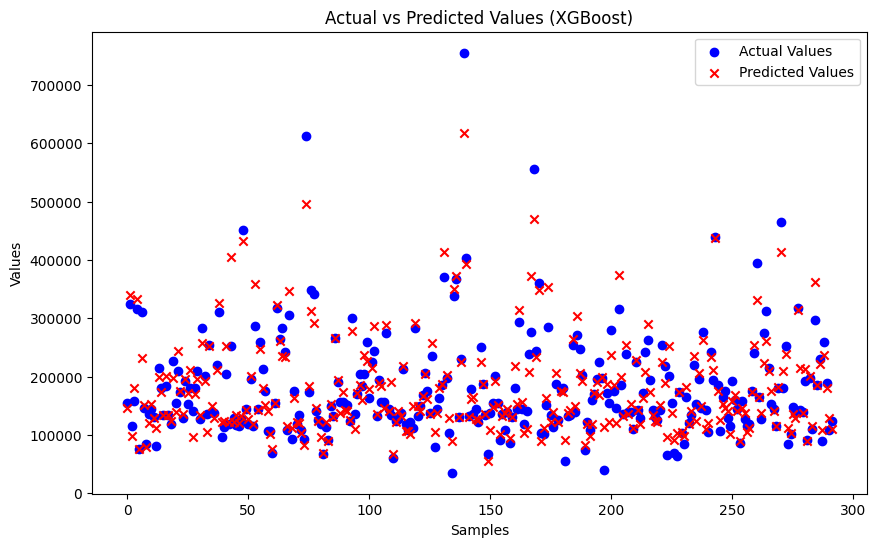

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', color='blue', marker='o')
plt.scatter(range(len(y_pred_xgb)), y_pred_xgb, label='Predicted Values', color='red', marker='x')
plt.title('Actual vs Predicted Values (XGBoost)')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

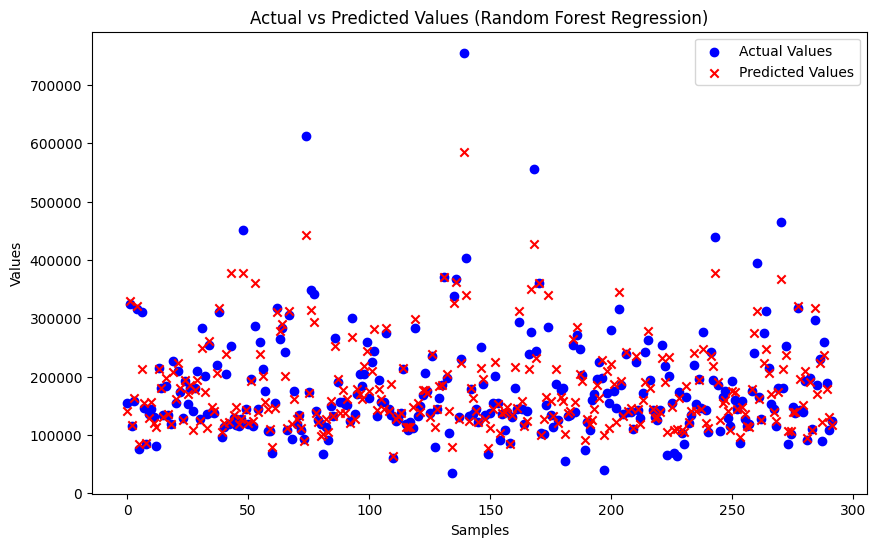

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', color='blue', marker='o')
plt.scatter(range(len(y_pred_rand_forest_reg)), y_pred_rand_forest_reg, label='Predicted Values', color='red', marker='x')
plt.title('Actual vs Predicted Values (Random Forest Regression)')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

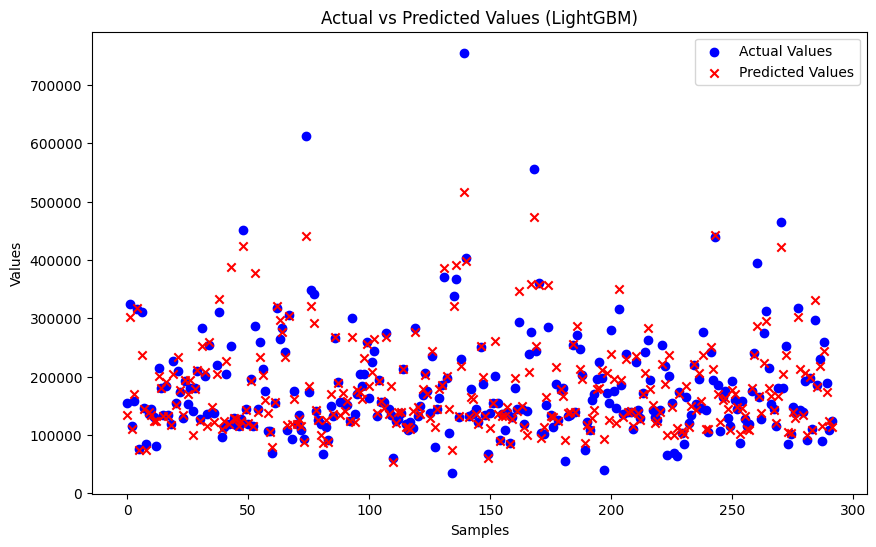

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', color='blue', marker='o')
plt.scatter(range(len(y_pred_lgb)), y_pred_lgb, label='Predicted Values', color='red', marker='x')
plt.title('Actual vs Predicted Values (LightGBM)')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

## Result

In [23]:
df_te_x = df_te.drop(columns=["SalePrice"])
df_test_lgb = lgb_model.predict(df_te_x)

In [24]:
output = pd.DataFrame({
    'Id': df_te_x['Id'], 
    'SalePrice': df_test_lgb
})

output.to_csv('submission.csv', index=False)